<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/ON4_RapidAPI_YFinanceJSON_Read_Hourly_Data_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import requests

url = "https://yahoo-finance127.p.rapidapi.com/historic/XU100.IS/1h/3mo"

headers = {
	"X-RapidAPI-Key": "c4100a6817msh6100fdd804b1ae8p1defa4jsn72757c98b3c0",
	"X-RapidAPI-Host": "yahoo-finance127.p.rapidapi.com"
}

response = requests.get(url, headers=headers)

print(response.json())

{'meta': {'currency': 'TRY', 'symbol': 'XU100.IS', 'exchangeName': 'IST', 'instrumentType': 'INDEX', 'firstTradeDate': 867738600, 'regularMarketTime': 1692371411, 'gmtoffset': 10800, 'timezone': 'TRT', 'exchangeTimezoneName': 'Europe/Istanbul', 'regularMarketPrice': 7513.29, 'chartPreviousClose': 4501.7, 'previousClose': 7764.47, 'scale': 3, 'priceHint': 2, 'currentTradingPeriod': {'pre': {'timezone': 'TRT', 'end': 1692340200, 'start': 1692340200, 'gmtoffset': 10800}, 'regular': {'timezone': 'TRT', 'end': 1692370800, 'start': 1692340200, 'gmtoffset': 10800}, 'post': {'timezone': 'TRT', 'end': 1692370800, 'start': 1692370800, 'gmtoffset': 10800}}, 'tradingPeriods': [[{'timezone': 'TRT', 'end': 1684767600, 'start': 1684737000, 'gmtoffset': 10800}], [{'timezone': 'TRT', 'end': 1684854000, 'start': 1684823400, 'gmtoffset': 10800}], [{'timezone': 'TRT', 'end': 1684940400, 'start': 1684909800, 'gmtoffset': 10800}], [{'timezone': 'TRT', 'end': 1685026800, 'start': 1684996200, 'gmtoffset': 108

In [13]:
if response.status_code == 200:
    data = response.json()

    # Extract the "close" data
    close_data = data['indicators']['quote'][0]['close']

    # # Create a DataFrame from the "close" data
    # df = pd.DataFrame({'Close': close_data})

    # print(df)

In [14]:
import pandas as pd
timestamps = data["timestamp"]


# Convert timestamps to datetime
timestamps = [pd.to_datetime(ts, unit="s") for ts in timestamps]
timestamps = [ts + pd.Timedelta(hours=3) for ts in timestamps]

# Create a DataFrame
#df = pd.DataFrame({"Date-Time": timestamps, "Close": close_data})
df = pd.DataFrame({"Close": close_data}, index=timestamps)

df[df.index >"2023-08-18 00:00:00"]

,Close
2023-08-18 09:30:00,7784.759766
2023-08-18 10:30:00,7766.319824
2023-08-18 11:30:00,7741.810059
2023-08-18 12:30:00,7759.810059
2023-08-18 13:30:00,7701.569824
2023-08-18 14:30:00,7684.370117
2023-08-18 15:30:00,7647.759766
2023-08-18 16:30:00,7526.529785
2023-08-18 17:30:00,7515.930176
2023-08-18 18:00:00,7513.290039


In [15]:
# Create an empty list to store the split DataFrames
split_dataframes = []

# Define the start and end times
start_time = pd.to_datetime("09:30:00").time()
end_time = pd.to_datetime("18:00:00").time()

# Iterate through the DataFrame and split it
for date in df.index.to_series().dt.date.unique():
    daily_data = df[df.index.to_series().dt.date == date]  # Filter data for the current date

    # Filter data for the specified time range
    daily_data = daily_data[(daily_data.index.time >= start_time) & (daily_data.index.time <= end_time)]

    if not daily_data.empty:
        split_dataframes.append(daily_data)

# Print the split DataFrames
for i, split_df in enumerate(split_dataframes):
    print(f"DataFrame {i + 1}:\n{split_df}\n")


DataFrame 1:
                           Close
2023-05-22 09:30:00  4471.270020
2023-05-22 10:30:00  4466.629883
2023-05-22 11:30:00  4481.470215
2023-05-22 12:30:00  4486.109863
2023-05-22 13:30:00  4470.259766
2023-05-22 14:30:00  4487.350098
2023-05-22 15:30:00  4490.419922
2023-05-22 16:30:00  4460.839844
2023-05-22 17:30:00  4468.509766

DataFrame 2:
                           Close
2023-05-23 09:30:00  4464.020020
2023-05-23 10:30:00  4467.410156
2023-05-23 11:30:00  4471.350098
2023-05-23 12:30:00  4447.359863
2023-05-23 13:30:00  4465.609863
2023-05-23 14:30:00  4485.450195
2023-05-23 15:30:00  4475.509766
2023-05-23 16:30:00  4484.680176
2023-05-23 17:30:00  4473.959961

DataFrame 3:
                           Close
2023-05-24 09:30:00  4495.919922
2023-05-24 10:30:00  4510.529785
2023-05-24 11:30:00  4484.430176
2023-05-24 12:30:00  4451.390137
2023-05-24 13:30:00  4441.109863
2023-05-24 14:30:00  4424.490234
2023-05-24 15:30:00  4444.939941
2023-05-24 16:30:00  4425.950195
20

In [16]:
import numpy as np

# Create empty lists to store peak and lowest price information
peak_hours = []
lowest_hours = []
peak_prices = []
lowest_prices = []

# Iterate through the split DataFrames
for split_df in split_dataframes:
    # Find the timestamp with the maximum price
    max_price_timestamp = split_df["Close"].idxmax()
    max_price = split_df["Close"].max()

    # Find the timestamp with the lowest price
    min_price_timestamp = split_df["Close"].idxmin()
    min_price = split_df["Close"].min()

    # Append the information to the respective lists
    peak_hours.append(max_price_timestamp)
    lowest_hours.append(min_price_timestamp)
    peak_prices.append(max_price)
    lowest_prices.append(min_price)

# Find the overall peak and lowest prices and their corresponding hours
overall_peak_index = np.argmax(peak_prices)
overall_lowest_index = np.argmin(lowest_prices)

overall_peak_hour = peak_hours[overall_peak_index]
overall_lowest_hour = lowest_hours[overall_lowest_index]
overall_peak_price = peak_prices[overall_peak_index]
overall_lowest_price = lowest_prices[overall_lowest_index]

print(f"Overall Peak Price: {overall_peak_price} at {overall_peak_hour}")
print(f"Overall Lowest Price: {overall_lowest_price} at {overall_lowest_hour}")


Overall Peak Price: 7851.490234375 at 2023-08-14 11:30:00
Overall Lowest Price: 4417.18017578125 at 2023-05-25 16:30:00


In [17]:
# Create an empty list to store results
results = []

# Iterate through the split DataFrames
for i, split_df in enumerate(split_dataframes):
    # Find the timestamp with the highest and lowest prices
    peak_timestamp = split_df['Close'].idxmax()
    lowest_timestamp = split_df['Close'].idxmin()

    # Extract the corresponding prices
    peak_price = split_df['Close'].loc[peak_timestamp]
    lowest_price = split_df['Close'].loc[lowest_timestamp]

    # Append the results for this piece of data to the list
    results.append({
        'DataFrame': i + 1,
        'Peak Hour': peak_timestamp,
        'Peak Price': peak_price,
        'Lowest Hour': lowest_timestamp,
        'Lowest Price': lowest_price
    })

# Convert the results list to a DataFrame for better presentation
results_df = pd.DataFrame(results)

# Print the results
print(results_df)


    DataFrame           Peak Hour   Peak Price         Lowest Hour  \
0           1 2023-05-22 15:30:00  4490.419922 2023-05-22 16:30:00   
1           2 2023-05-23 14:30:00  4485.450195 2023-05-23 12:30:00   
2           3 2023-05-24 10:30:00  4510.529785 2023-05-24 14:30:00   
3           4 2023-05-25 12:30:00  4454.529785 2023-05-25 16:30:00   
4           5 2023-05-26 16:30:00  4591.629883 2023-05-26 09:30:00   
..        ...                 ...          ...                 ...   
57         58 2023-08-14 11:30:00  7851.490234 2023-08-14 15:30:00   
58         59 2023-08-15 14:30:00  7740.370117 2023-08-15 16:30:00   
59         60 2023-08-16 16:30:00  7700.509766 2023-08-16 09:30:00   
60         61 2023-08-17 12:30:00  7796.819824 2023-08-17 09:30:00   
61         62 2023-08-18 09:30:00  7784.759766 2023-08-18 18:00:00   

    Lowest Price  
0    4460.839844  
1    4447.359863  
2    4424.490234  
3    4417.180176  
4    4457.120117  
..           ...  
57   7729.100098  
58   76

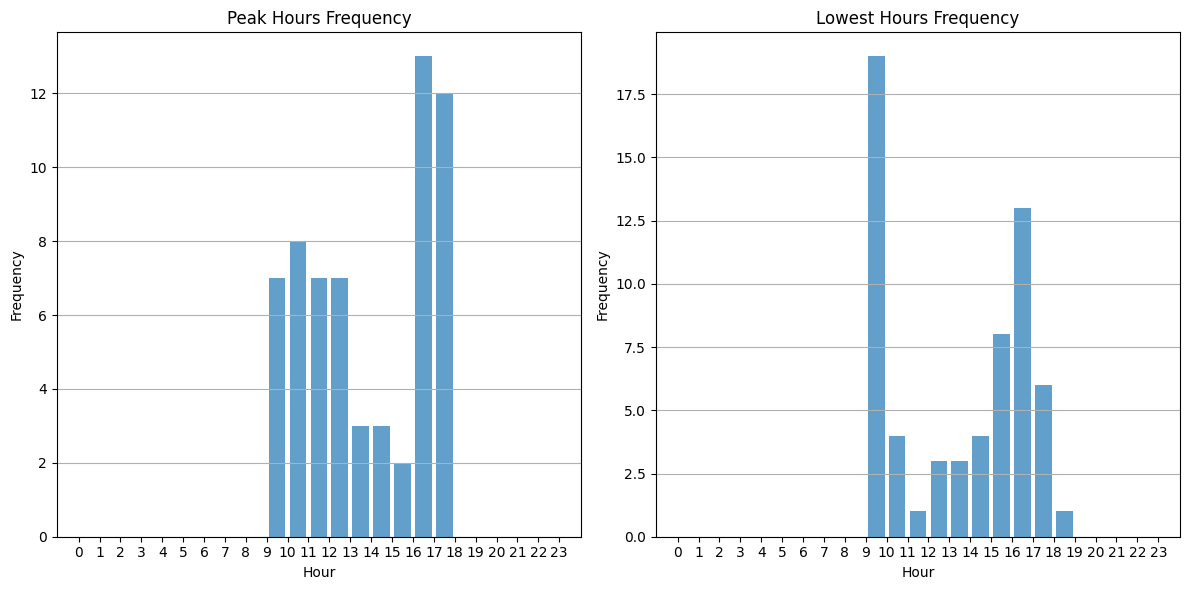

In [18]:
import matplotlib.pyplot as plt

# Create histograms for peak hours and lowest hours
plt.figure(figsize=(12, 6))

# Histogram for peak hours
plt.subplot(1, 2, 1)
plt.hist(results_df['Peak Hour'].dt.hour, bins=range(0, 24), rwidth=0.8, alpha=0.7)
plt.title('Peak Hours Frequency')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))
plt.grid(axis='y')

# Histogram for lowest hours
plt.subplot(1, 2, 2)
plt.hist(results_df['Lowest Hour'].dt.hour, bins=range(0, 24), rwidth=0.8, alpha=0.7)
plt.title('Lowest Hours Frequency')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))
plt.grid(axis='y')

# Adjust spacing between subplots
plt.tight_layout()

# Show the histograms
plt.show()


In [19]:
# ///////////////////////////////////////////////////////////
# FUNCTIONS FOR ALPHA VANTAGE
# ///////////////////////////////////////////////////////////
TIME_SERIES_INTRADAY = 'TIME_SERIES_INTRADAY'
TIME_SERIES_INTRADAY_EXTENDED = 'TIME_SERIES_INTRADAY_EXTENDED'
TIME_SERIES_DAILY = 'TIME_SERIES_DAILY'
TIME_SERIES_DAILY_ADJUSTED = 'TIME_SERIES_DAILY_ADJUSTED'
TIME_SERIES_WEEKLY = 'TIME_SERIES_WEEKLY'
TIME_SERIES_WEEKLY_ADJUSTED = 'TIME_SERIES_WEEKLY_ADJUSTED'
TIME_SERIES_MONTHLY = 'TIME_SERIES_MONTHLY'
TIME_SERIES_MONTHLY_ADJUSTED = 'TIME_SERIES_MONTHLY_ADJUSTED'

# ///////////////////////////////////////////////////////////
# TIME SERIES FOR STOCK DATA
# ///////////////////////////////////////////////////////////
ONEMIN = 'Time Series (1min)'
FIVEMIN = 'Time Series (5min)'
FIVETEENMIN = 'Time Series (15min)'
THIRTYMIN = 'Time Series (30min)'
HOUR = 'Time Series (60min)'
FIVEMIN = 'Time Series (5min)'
DAILY = 'Time Series (Daily)'
WEEKLY = 'Weekly Time Series'
WEEKLY_ADJ = 'Weekly Adjusted Time Series'
MONTLY = 'Monthly Time Series'
MONTLY_ADJ = 'Monthly Adjusted Time Series'

# /////////////////////////////////////////////////////////
# query timeseries stock data of selected type ////////////
# /////////////////////////////////////////////////////////
def query_timeseries_data(func, symbol, outputsize='full', datatype='json', apikey='AN5SOF59K41U0YQ3'):
    data = {
        "function": func, # Here you can put any of the 'funcs' above
        "symbol": symbol,
        "outputsize": outputsize, # (full) and (compact) are accepted
        "datatype": datatype,
        "apikey": apikey
    }
    return requests.get("https://www.alphavantage.co/query", data).json()

# /////////////////////////////////////////////////////////
# convert timeseries stock data of selected type to json //
# /////////////////////////////////////////////////////////
def get_timeseries_dataframe(json, type):
    df = pd.DataFrame.from_dict(json[type], orient= 'index')
    df.index =  pd.to_datetime(df.index, format='%Y-%m-%d')

    df = df.rename(columns={ '1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'})
    df = df.astype({'Open': 'float64', 'High': 'float64', 'Low': 'float64','Close': 'float64','Volume': 'float64',})
    df = df[[ 'Open', 'High', 'Low', 'Close', 'Volume']]
    return df

# Now all you have to do is actually call the funcs
response_json = query_timeseries_data(TIME_SERIES_DAILY, 'MSFT')
stockprice_dataframe = get_timeseries_dataframe(response_json, DAILY)
